Yarışma: https://www.kaggle.com/competitions/sa-customer-segmentation/leaderboard#

In [78]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle competitions download -c sa-customer-segmentation

  0% 0.00/2.75M [00:00<?, ?B/s]
100% 2.75M/2.75M [00:00<00:00, 154MB/s]


In [79]:
!unzip sa-customer-segmentation.zip

Archive:  sa-customer-segmentation.zip
  inflating: flight_test.csv         
  inflating: flight_train.csv        
  inflating: sample.csv              


In [80]:
pip install pandas matplotlib seaborn scikit-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [25]:
# Veri setlerini yükle
train_data = pd.read_csv('flight_train.csv')
test_data = pd.read_csv('flight_test.csv')

In [3]:
train_data.head(2)

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER WORK_CITY  \
0      54993  11/2/2006        12/24/2008   Male         6         .   
1      28065  2/19/2007          8/3/2007   Male         6       NaN   

  WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  SUM_YR_2  SEG_KM_SUM  \
0       beijing           CN  31.0  3/31/2014  ...  234188.0      580717   
1       beijing           CN  42.0  3/31/2014  ...  167434.0      293678   

   LAST_FLIGHT_DATE  LAST_TO_END  AVG_INTERVAL MAX_INTERVAL  EXCHANGE_COUNT  \
0         3/31/2014            1      3.483254           18              34   
1         3/25/2014            7      5.194245           17              29   

   avg_discount  Points_Sum  Point_NotFlight  
0      0.961639      619760               50  
1      1.252314      415768               33  

[2 rows x 23 columns]

Veri Ön İşleme

In [84]:
train_data.isnull().sum()

MEMBER_NO               0
FFP_DATE                0
FIRST_FLIGHT_DATE       0
GENDER                  3
FFP_TIER                0
WORK_CITY            1966
WORK_PROVINCE        2784
WORK_COUNTRY           20
AGE                   342
LOAD_TIME               0
FLIGHT_COUNT            0
BP_SUM                  0
SUM_YR_1              262
SUM_YR_2               63
SEG_KM_SUM              0
LAST_FLIGHT_DATE        0
LAST_TO_END             0
AVG_INTERVAL            0
MAX_INTERVAL            0
EXCHANGE_COUNT          0
avg_discount            0
Points_Sum              0
Point_NotFlight         0
dtype: int64

Eksik Değer Oranı

In [4]:
missing_values = train_data.isnull().sum()
missing_percentage = (missing_values / len(train_data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_data[missing_data['Missing Values'] > 0])

               Missing Values  Percentage
GENDER                      3    0.005455
WORK_CITY                1966    3.574545
WORK_PROVINCE            2784    5.061818
WORK_COUNTRY               20    0.036364
AGE                       342    0.621818
SUM_YR_1                  262    0.476364
SUM_YR_2                   63    0.114545


In [26]:
# Kategorik değişkenler için mod ile doldurma
train_data['GENDER'].fillna(train_data['GENDER'].mode()[0], inplace=True)
train_data['WORK_CITY'].fillna(train_data['WORK_CITY'].mode()[0], inplace=True)
train_data['WORK_COUNTRY'].fillna(train_data['WORK_COUNTRY'].mode()[0], inplace=True)

In [27]:
# Sayısal değişkenler için medyan ile doldurma
train_data['AGE'].fillna(train_data['AGE'].median(), inplace=True)
train_data['SUM_YR_1'].fillna(train_data['SUM_YR_1'].median(), inplace=True)
train_data['SUM_YR_2'].fillna(train_data['SUM_YR_2'].median(), inplace=True)

In [28]:
# WORK_PROVINCE sütununu kaldırma
train_data.drop(columns=['WORK_PROVINCE'], inplace=True)

In [8]:
train_data.isnull().sum().sum()

0

Keşifsel Veri Analizi (EDA)

In [91]:
train_data.describe()

MEMBER_NO      FFP_TIER           AGE  FLIGHT_COUNT         BP_SUM  \
count  55000.000000  55000.000000  55000.000000  55000.000000   55000.000000   
mean   31549.707145      4.115727     42.701400     13.213527   12362.465164   
std    18177.005101      0.395579      9.773425     14.528764   17012.468908   
min        1.000000      4.000000      6.000000      2.000000       0.000000   
25%    15798.750000      4.000000     35.000000      4.000000    3497.000000   
50%    31559.500000      4.000000     42.000000      8.000000    6903.000000   
75%    47322.250000      4.000000     48.000000     16.000000   14481.000000   
max    62988.000000      6.000000    110.000000    213.000000  505308.000000   

            SUM_YR_1       SUM_YR_2     SEG_KM_SUM   LAST_TO_END  \
count   55000.000000   55000.000000   55000.000000  55000.000000   
mean     5990.303660    6322.390018   19256.688255    155.593436   
std      8439.766787    9076.111972   21613.796416    169.987954   
min         0.000000       0.000000    1380.000000      1.000000   
25%      1410.000000    1300.000000    6332.000000     25.000000   
50%      3426.500000    3484.000000   11983.000000     91.000000   
75%      7373.500000    7751.250000   23761.500000    226.000000   
max    239560.000000  234188.000000  580717.000000    730.000000   

       AVG_INTERVAL  MAX_INTERVAL  EXCHANGE_COUNT  avg_discount    Points_Sum  \
count  55000.000000  55000.000000    55000.000000  55000.000000   55000.00000   
mean      62.979631    172.201745        0.361727      0.736753   14102.26780   
std       64.506386    117.382011        1.201922      0.177283   21049.88039   
min        0.000000      0.000000        0.000000      0.136017       0.00000   
25%       25.166667     90.000000        0.000000      0.629210    3796.00000   
50%       44.600000    149.000000        0.000000      0.720056    7611.00000   
75%       77.500000    230.000000        0.000000      0.813888   16046.75000   
max      714.000000    719.000000       46.000000      1.500000  795398.00000   

       Point_NotFlight  
count     55000.000000  
mean          2.827073  
std           7.526118  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max         140.000000

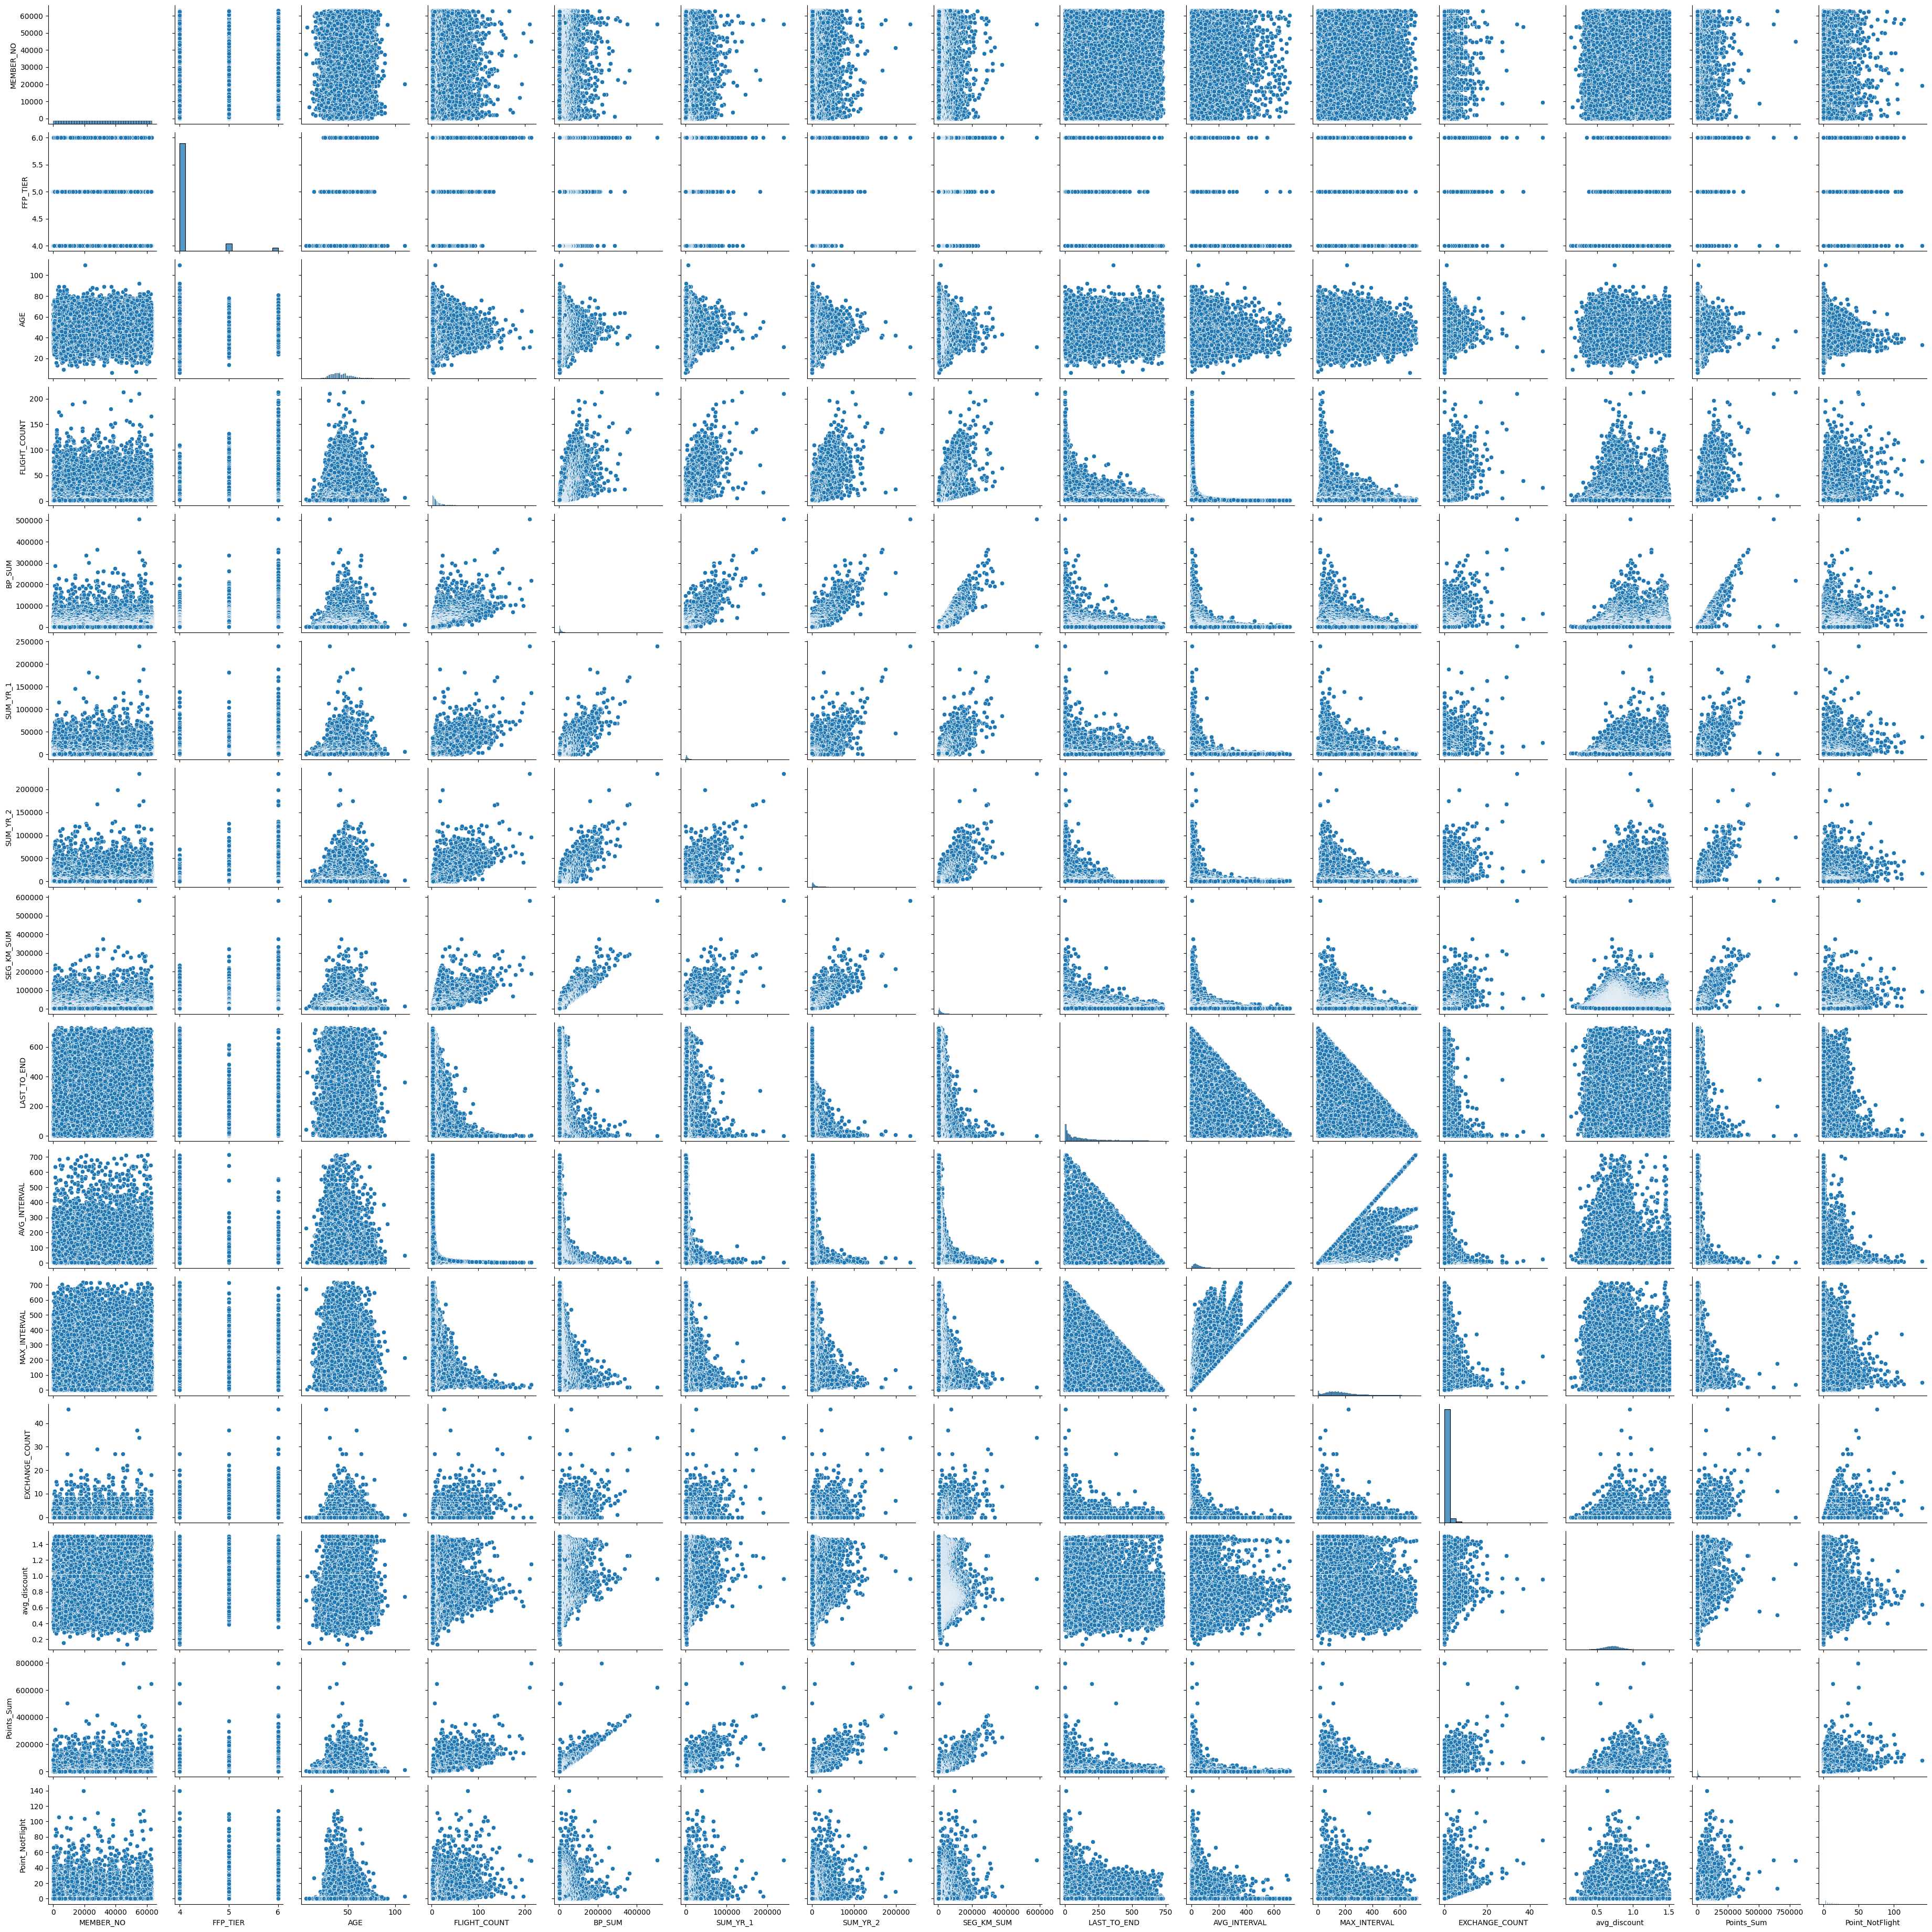

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(train_data)
plt.show()

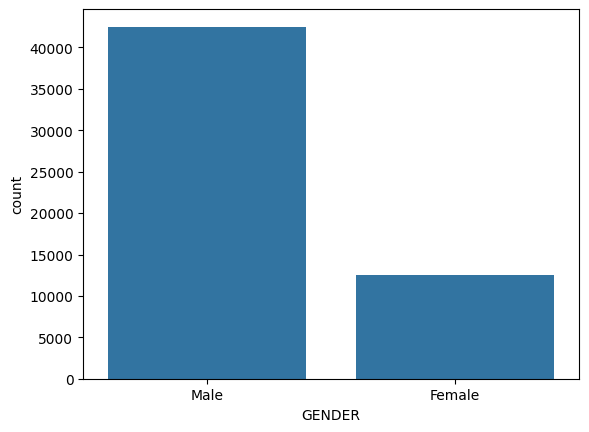

In [93]:
sns.countplot(x='GENDER', data=train_data)
plt.show()

Veri Ön İşleme

Sayısal değişkenleri standartlaştırma;

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_data.select_dtypes(include=[float, int]))

Kategorik değişkenleri sayısal verilere dönüştürme

In [10]:
#train_data = pd.get_dummies(train_data, columns=['GENDER', 'WORK_CITY', 'WORK_COUNTRY'])

### Modelleme

KMeans Kümeleme

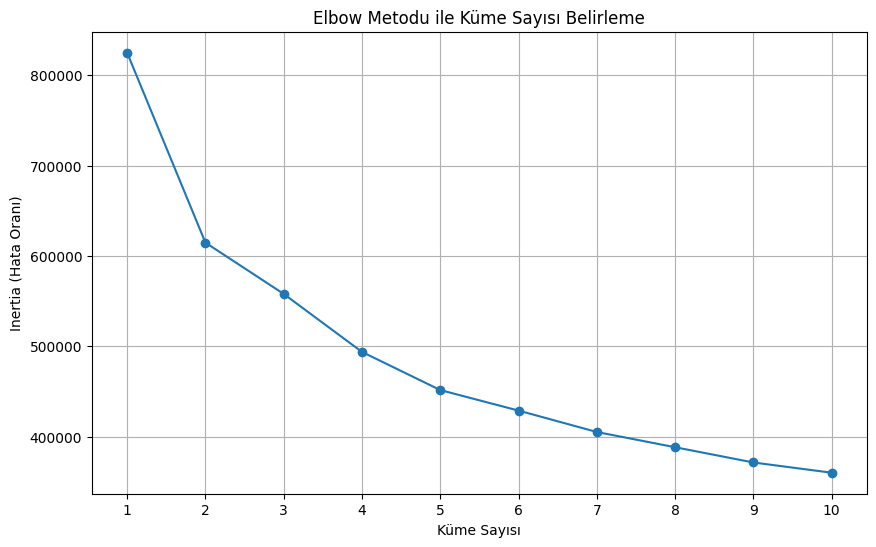

In [96]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Küme sayıları ve inertia değerlerini depolamak için listeler
inertia = []

# 1'den 10'a kadar küme sayıları için KMeans uygula
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)  # Ölçeklendirilmiş özellikler
    inertia.append(kmeans.inertia_)

# Elbow grafiğini çiz
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Metodu ile Küme Sayısı Belirleme')
plt.xlabel('Küme Sayısı')
plt.ylabel('Inertia (Hata Oranı)')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)  # Küme sayısını ayarla
train_data['Cluster'] = kmeans.fit_predict(scaled_features)

In [13]:
print(train_data.columns)

Index(['MEMBER_NO', 'FFP_DATE', 'FIRST_FLIGHT_DATE', 'FFP_TIER', 'AGE',
       'LOAD_TIME', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2',
       ...
       'WORK_COUNTRY_VN', 'WORK_COUNTRY_VT', 'WORK_COUNTRY_YE',
       'WORK_COUNTRY_ZA', 'WORK_COUNTRY_ZW', 'WORK_COUNTRY_中',
       'WORK_COUNTRY_北', 'WORK_COUNTRY_沈', 'WORK_COUNTRY_芬', 'Cluster'],
      dtype='object', length=3088)


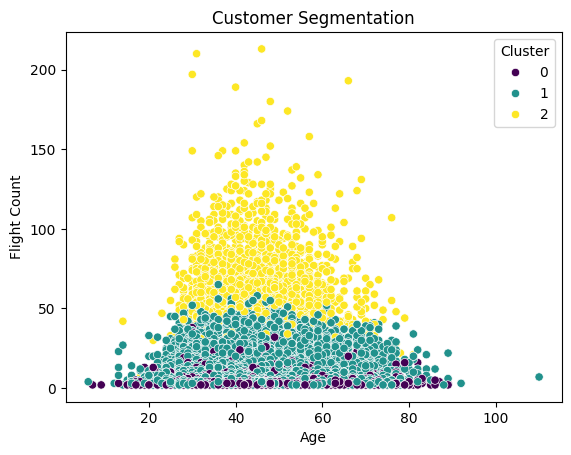

In [18]:
train_data['Cluster'] = kmeans.labels_
# Uygun sütun isimlerini kullanarak scatter plot oluştur
sns.scatterplot(data=train_data, x='AGE', y='FLIGHT_COUNT', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Age')
plt.ylabel('Flight Count')
plt.show()

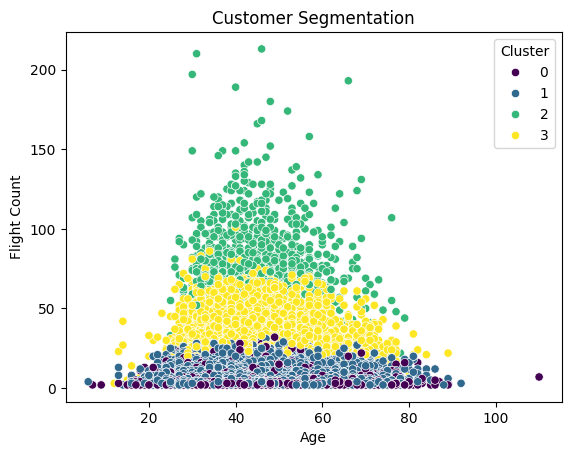

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)  # Küme sayısını ayarla
train_data['Cluster'] = kmeans.fit_predict(scaled_features)

train_data['Cluster'] = kmeans.labels_
# Uygun sütun isimlerini kullanarak scatter plot oluştur
sns.scatterplot(data=train_data, x='AGE', y='FLIGHT_COUNT', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Age')
plt.ylabel('Flight Count')
plt.show()

Test Verisi Üzerinde Tahmin

In [32]:
test_data.columns

Index(['MEMBER_NO', 'FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'FFP_TIER',
       'WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY', 'AGE', 'LOAD_TIME',
       'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2', 'SEG_KM_SUM',
       'LAST_FLIGHT_DATE', 'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL',
       'EXCHANGE_COUNT', 'avg_discount', 'Points_Sum', 'Point_NotFlight',
       'Cluster'],
      dtype='object')

In [37]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [39]:
# Test verisini yükle
test_data = pd.read_csv('flight_test.csv')

# Eksik değerleri impute et
test_data.fillna({
    'GENDER': test_data['GENDER'].mode()[0],
    'WORK_CITY': test_data['WORK_CITY'].mode()[0],
    'WORK_COUNTRY': test_data['WORK_COUNTRY'].mode()[0],
    'AGE': test_data['AGE'].median(),
    'SUM_YR_1': test_data['SUM_YR_1'].median(),
    'SUM_YR_2': test_data['SUM_YR_2'].median()
}, inplace=True)

# Test verisini standartlaştırma (Cluster sütunu hariç)
numeric_columns = test_data.select_dtypes(include=[float, int]).columns.tolist()
scaled_test_data = scaler.transform(test_data[numeric_columns])

# Kümeleme için tahmin yap
test_data['Cluster'] = kmeans.predict(scaled_test_data)

# Submission dosyası için doğru sütunları seçin
submission_data = test_data[['MEMBER_NO', 'FLIGHT_COUNT']]  # 'Cluster' dahil edilmemeli
submission_data.to_csv('segmented_test_data.csv', index=False)